## Prerequisite Installation

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip install fiftyone
! pip install faiss-cpu

In [ ]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

## Loading the CLIP model

In [ ]:
import clip
clip.available_models()

In [ ]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

## Loading the COCO dataset

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

coco_dataset = foz.load_zoo_dataset(
    name = "coco-2017",
    split = "validation",
    label_types = ["segmentations"]
)

## Making images and texts List

In [7]:
## the NUMBER of embedded vectors
## Train split: 118,287 images
# Test split: 40,670 images
# Validation split: 5,000 images

len = 5000 

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
original_images = []
images = []
texts = []

for coco_data in coco_dataset[:len]:

  if coco_data and coco_data.ground_truth:
    
    original_images.append(Image.open(coco_data.filepath))
    images.append(preprocess(Image.open(coco_data.filepath)))

    # ground truth is a dict, ground truth["detections"] is a list
    # every element of the list is a dict itself
    text = "This is a photo of"
    labels = []
    first_label = True

    for det in coco_data.ground_truth["detections"]:
      label = det["label"] 
      if label not in labels:
        labels.append(label)
        if first_label:
          text = text + " a " + label
          first_label = False
        else:
          text = text + " and a " + label
  
    texts.append(text)
    

## Embedding the images and texts

In [9]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(texts).cuda()

with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()
    
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

image_vec = image_features.cpu().numpy()
text_vec = text_features.cpu().numpy()

### result

(8.5, -2.0)

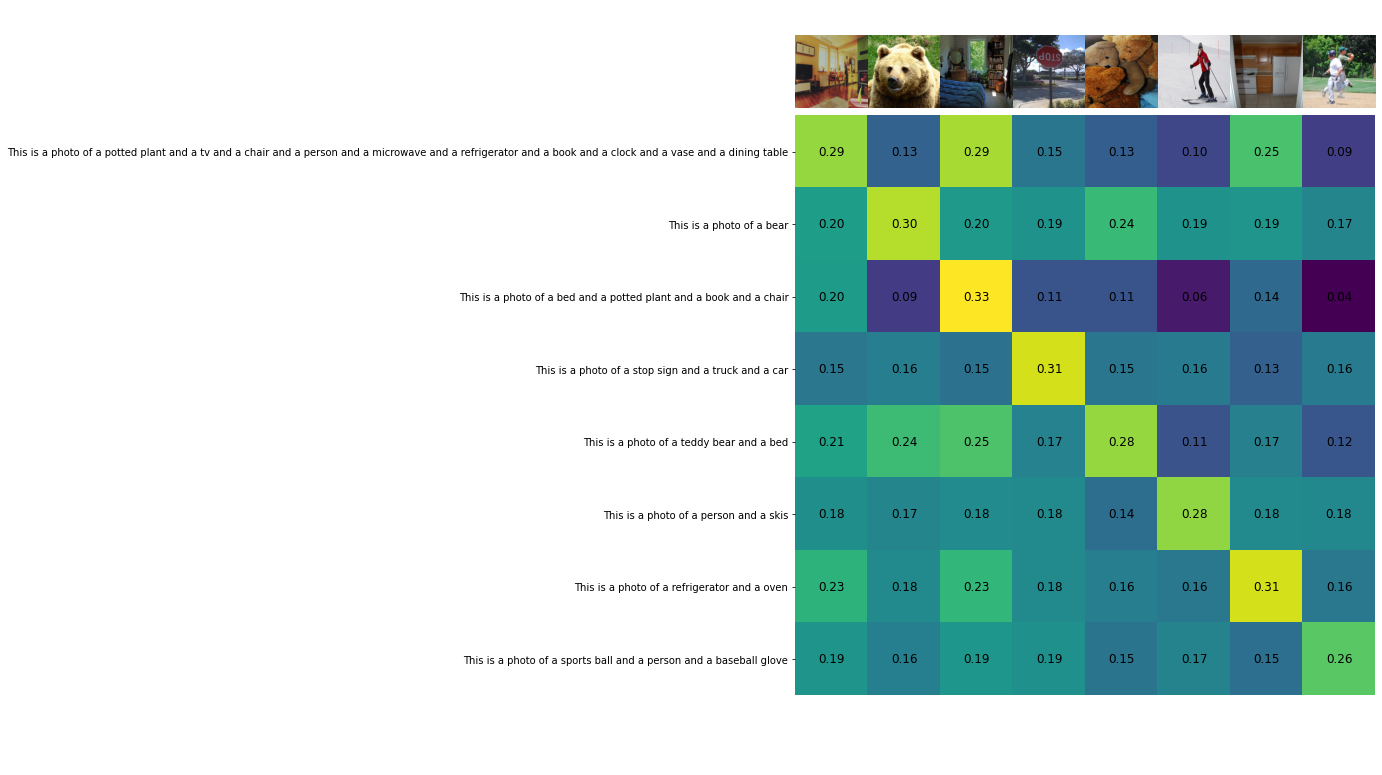

In [10]:
count = 8
similarity = text_vec[:count] @ image_vec[:count].T

plt.figure(figsize=(20,14))
plt.imshow(similarity)
plt.yticks(range(count), texts, fontsize=10)
plt.xticks([])
for i, image in enumerate(original_images[:count]):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])


## Similarity search for heterogeneous data

In [82]:
import faiss                   

d = image_vec.shape[1]                         
index = faiss.IndexFlatL2(d)        # build the L2 index
index.add(image_vec)

def image_search(_original_images, k):

  _images = []
  for image in _original_images:
    _images.append(preprocess(image))

  _image_input = torch.tensor(np.stack(_images)).cuda()
  with torch.no_grad():
    _image_features = model.encode_image(_image_input).float()
  _image_features /= _image_features.norm(dim=-1, keepdim=True)
  _image_vec = _image_features.cpu().numpy()
  
  D, I = index.search(_image_vec, k) # search k nearest neighbors

  print("I")
  print(I)
  print("D")
  print(D)
  
  plt.figure(figsize=(20,14))
  count = I.shape[0]
  plt.yticks([])
  plt.xticks([])

  for i, image in enumerate(_original_images):
      plt.imshow(image, extent=(- 0.5, 0.5, -0.5 + i, 0.5 + i), origin="upper")
      for j, ind in enumerate(I[i]): 
        plt.imshow(original_images[ind], extent=(0.5+j, 1.5+j, -0.5 + i, 0.5 + i), origin="upper")


  for x in range(D.shape[0]):
      for y in range(D.shape[1]):
          plt.text(y+1, x, f"{D[x][y]:.2f}", position=(y+1.2,x-0.4), size=16)

  for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

  plt.xlim([-0.5, k+1 - 0.5])
  plt.ylim([-0.5, count - 0.5])
    

        
def text_search(_texts, k):
  _text_tokens = clip.tokenize(_texts).cuda()
  with torch.no_grad():
    _text_features = model.encode_text(_text_tokens).float()
  _text_features /= _text_features.norm(dim=-1, keepdim=True)
  _text_vec = _text_features.cpu().numpy()

  D, I = index.search(_text_vec, k) # search k nearest neighbors

  print("I")
  print(I)
  print("D")
  print(D)
  
  plt.figure(figsize=(20,14))
  count = I.shape[0]
  plt.yticks([])
  plt.xticks([])

  for i, text in enumerate(_texts):
      plt.text(-0.5, i, text, ha="left", va="center")
      for j, ind in enumerate(I[i]): 
        plt.imshow(original_images[ind], extent=(1.5+j, 2.5+j, -0.5 + i, 0.5 + i), origin="upper")


  for x in range(D.shape[0]):
      for y in range(D.shape[1]):
          plt.text(y+2, x, f"{D[x][y]:.2f}", position=(y+2.2,x-0.4), size=16)

  for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

  plt.xlim([-0.5, k+2 - 0.5])
  plt.ylim([-0.5, count - 0.5])

### sanity check 

[[   0 1302 4223 2902  564]
 [   1 2636 3094 1114 2037]
 [   2  564 4015  287 4941]
 [   3  109 2171  779 1667]
 [   4 4466  894  950 2368]]
[[1.6768100e-06 3.1835300e-01 3.2593411e-01 3.4255195e-01 3.4335345e-01]
 [7.4327608e-07 1.6084044e-01 1.6388206e-01 1.7734258e-01 1.9596148e-01]
 [1.2570256e-06 3.3559278e-01 3.5588866e-01 3.5721707e-01 3.5781157e-01]
 [2.9807391e-06 4.7509363e-01 4.7884154e-01 4.8534885e-01 5.3754926e-01]
 [2.1525109e-06 2.0963565e-01 2.8095964e-01 2.8504622e-01 2.8639263e-01]]


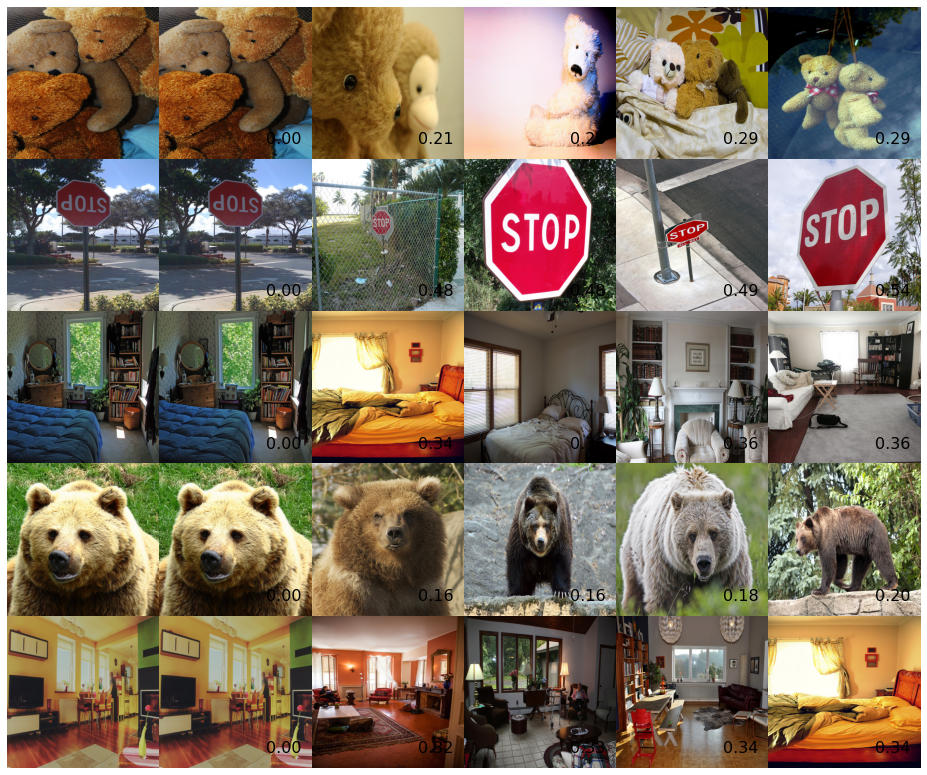

In [66]:
image_search(original_images[:5], 5)

I
[[3945 2636 3094 3574 4659]
 [   2 3447  355  698   21]
 [3937 1055    3 2651  779]
 [ 950 3806  388 2786 1946]
 [ 843 3018 3209 2928 2705]]
D
[[1.37568   1.3840668 1.3846742 1.3895168 1.3919299]
 [1.3374245 1.3723176 1.4098945 1.4272292 1.4408813]
 [1.3541646 1.373961  1.3760438 1.378612  1.3805192]
 [1.358752  1.3893642 1.3992853 1.413226  1.4152496]
 [1.3767922 1.3773022 1.3795094 1.3817657 1.3861309]]


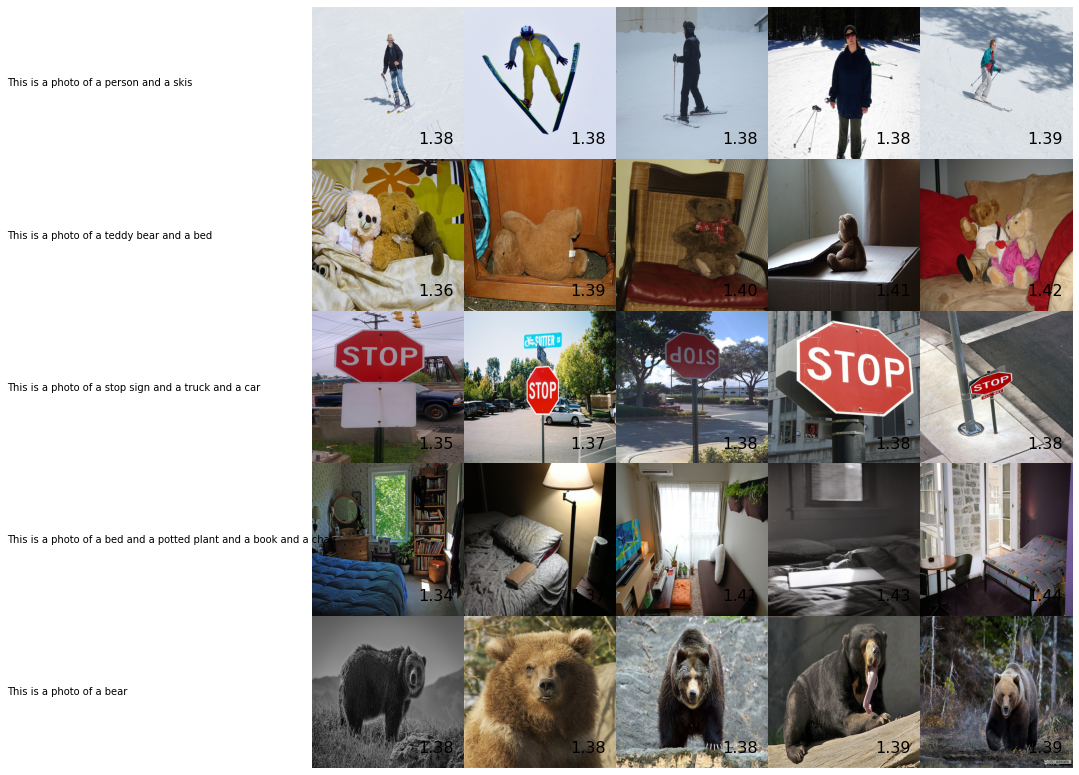

In [83]:
text_search(texts[1:6], 5)

### examples

In [ ]:
test_dataset = foz.load_zoo_dataset(
    name = "coco-2017",
    split = "train",
    label_types = ["segmentations"],
    max_samples = 100
)

In [14]:
test_images = []
test_texts = []

for test_data in test_dataset[:-1]:

  if test_data and test_data.ground_truth:
    
    test_images.append(Image.open(test_data.filepath))

    # ground truth is a dict, ground truth["detections"] is a list
    # every element of the list is a dict itself
    text = "This is a photo of"
    labels = []
    first_label = True

    for det in test_data.ground_truth["detections"]:
      label = det["label"] 
      if label not in labels:
        labels.append(label)
        if first_label:
          text = text + " a " + label
          first_label = False
        else:
          text = text + " and a " + label
  
    test_texts.append(text)

[[2516 1908  951]
 [4171 2939 1326]
 [4376 1183 1840]
 [1035  607 4702]
 [1015  314 2899]]
[[0.33689559 0.3439917  0.39289367]
 [0.18645123 0.19063595 0.2019045 ]
 [0.3239416  0.34096104 0.36295897]
 [0.10291868 0.12798554 0.13649869]
 [0.5106925  0.54188573 0.5604434 ]]


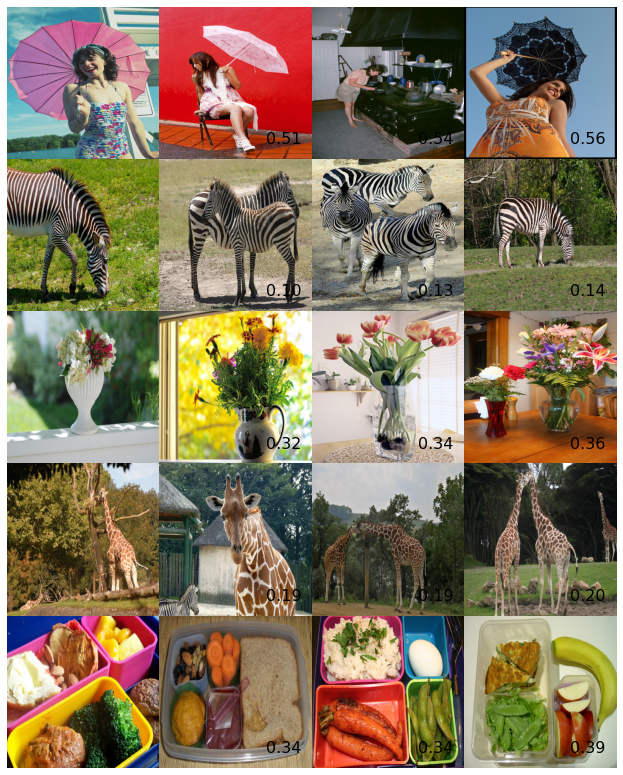

In [67]:
image_search(test_images[:5], 3)

I
[[1331 1997  191]
 [1835 1134 4581]
 [1442 3379  605]
 [4702 1035 3643]
 [3090 1008 1833]]
D
[[1.3665891 1.4135683 1.416818 ]
 [1.3136784 1.337122  1.3373265]
 [1.3673333 1.384742  1.3936616]
 [1.3336601 1.3361585 1.3376033]
 [1.3482258 1.3712122 1.3716052]]


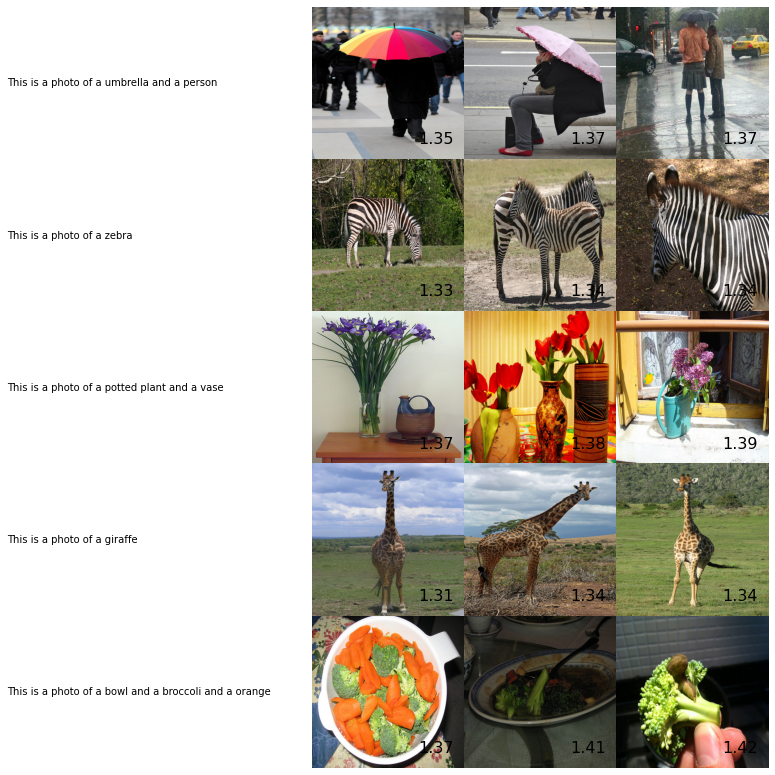

In [84]:
text_search(test_texts[:5],3)